In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import training
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list)

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd)

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd)

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd)

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd)

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd)

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?

15.06.2022 14:35:29 Creating Training Directory at 2022-06-15_14-35_MinCut_CG_Classifier/
15.06.2022 14:35:29 Loading Datasets
15.06.2022 14:35:29 Start Training


Epoch 0: Training loss 17.6288; Validation loss 22.1401, MAE: 22.3064; lr: 0.00000
	Add. Loss: Training 0.2592, Validation 0.2761
Epoch 5: Training loss 17.2966; Validation loss 21.7993, MAE: 22.0140; lr: 0.00010
	Add. Loss: Training 0.2519, Validation 0.2581
Epoch 10: Training loss 14.1120; Validation loss 18.5541, MAE: 18.7757; lr: 0.00020
	Add. Loss: Training 0.2492, Validation 0.2829
Epoch 15: Training loss 5.4032; Validation loss 14.9248, MAE: 15.1423; lr: 0.00030
	Add. Loss: Training 0.2727, Validation 0.2641
Epoch 20: Training loss 4.7846; Validation loss 15.5947, MAE: 15.8300; lr: 0.00040
	Add. Loss: Training 0.2602, Validation 0.2553
Epoch 25: Training loss 4.2718; Validation loss 15.2875, MAE: 15.5287; lr: 0.00050
	Add. Loss: Training 0.2539, Validation 0.2574
Epoch 30: Training loss 3.6774; Validation loss 14.7815, MAE: 15.0280; lr: 0.00060
	Add. Loss: Training 0.2512, Validation 0.2445
Epoch 35: Training loss 3.3121; Validation loss 15.0836, MAE: 15.3285; lr: 0.00070
	Add. 

15.06.2022 15:09:00 Training took 0.56 hours
15.06.2022 15:09:00 Minimum Training Loss -0.6462 in epoch 4998
15.06.2022 15:09:00 Minimum Validation Loss (after 100 epochs) 11.4916 in epoch 4820
15.06.2022 15:09:00 Minimum MAE (after 100 epochs) 12.4089 in epoch 4820
15.06.2022 15:09:00 Seed used for training was: 3653027422642386100


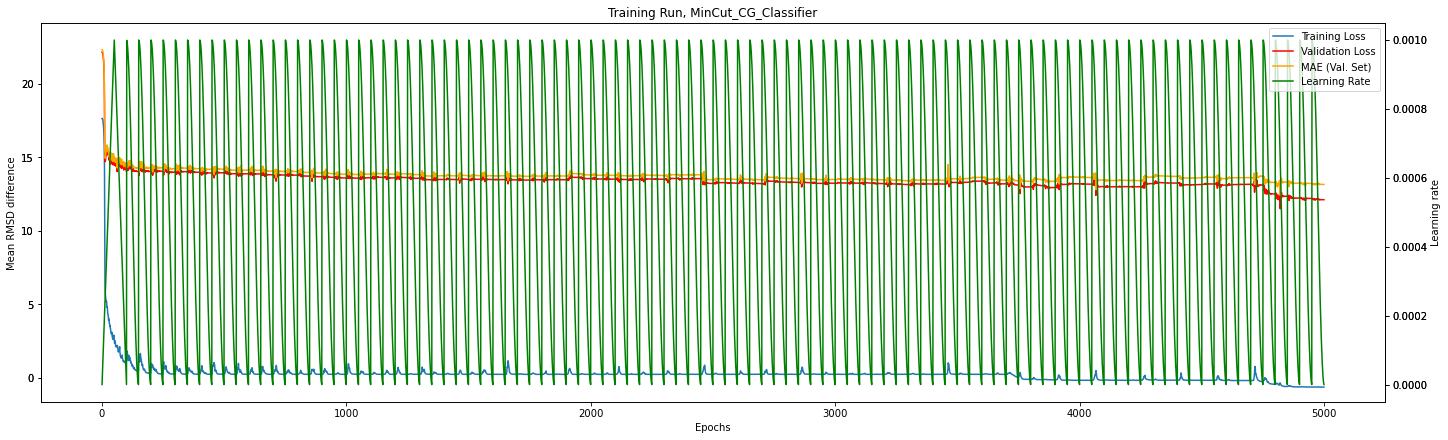

In [8]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=100)

In [3]:
#get training run data

run_dir = "run_data/2022-06-15_13-56_MinCut_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss -0.6202 in epoch 4503
Minimum Validation Loss (after 50 epochs) 12.2632 in epoch 4686
Minimum MAE (after 50 epochs) 13.3250 in epoch 2867


Validation Loss at 2867 is 12.6835
5 before select
13.0107, 13.2714, 13.0793, 13.3109, 13.2018
5 after select
12.6332, 12.9948, 13.3526, 12.8716, 12.8602
MAE at 2867 is 13.3250


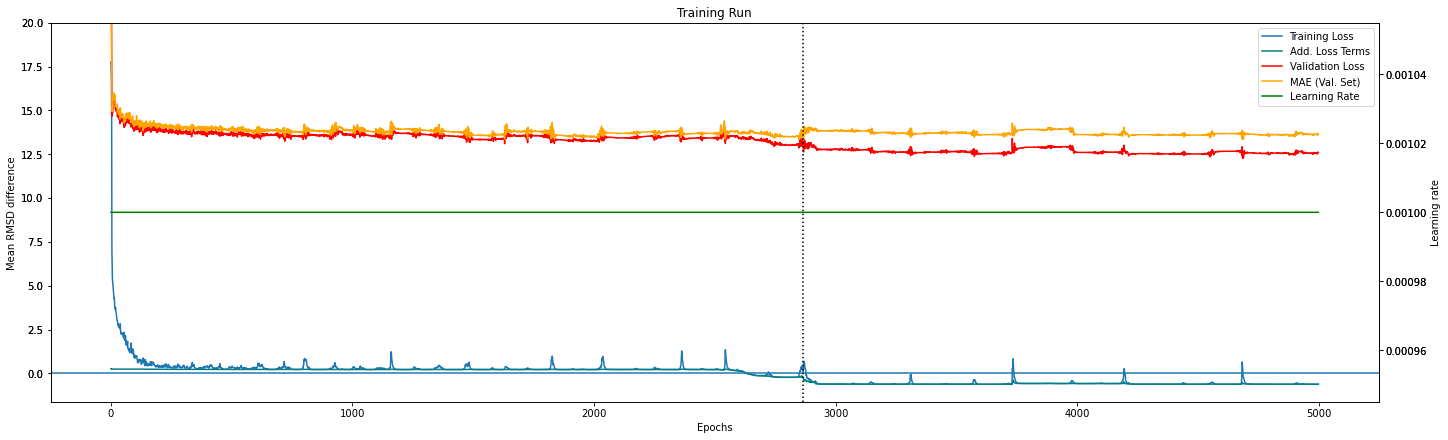

In [6]:
#plot the training run
select = 2867

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 2867
Test Set
Minimum Loss: Label = 22.3780, Prediction = 22.4185, Loss = 0.0008
Maximum Loss: Label = 0.0000, Prediction = 29.1213, Loss = 28.6213
Mean Test loss: 	 11.8434
Std. Dev. of Test loss:  8.0741
Min loss: 		 0.0008
First Quantile: 	 4.5102
Median: 		 10.6853
Third Quantile: 	 17.8476
Max Loss: 		 28.6213
LinregressResult(slope=-0.32235825439123067, intercept=24.00098244853511, rvalue=-0.10677106983738441, pvalue=0.07605263930009949, stderr=0.181021076684144, intercept_stderr=4.105774361454699)


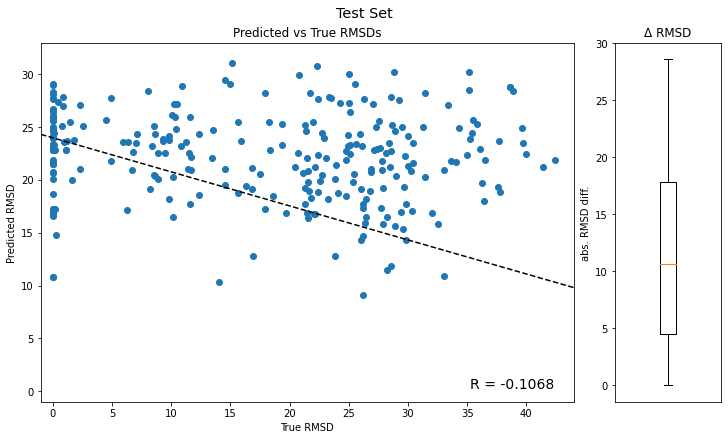

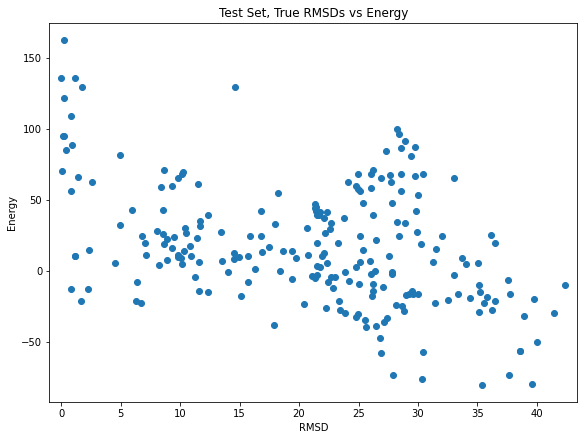

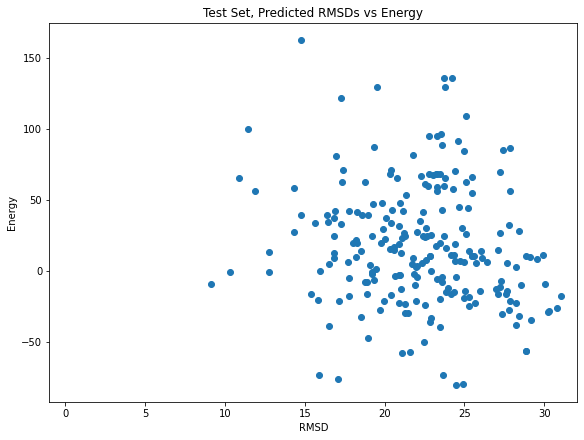

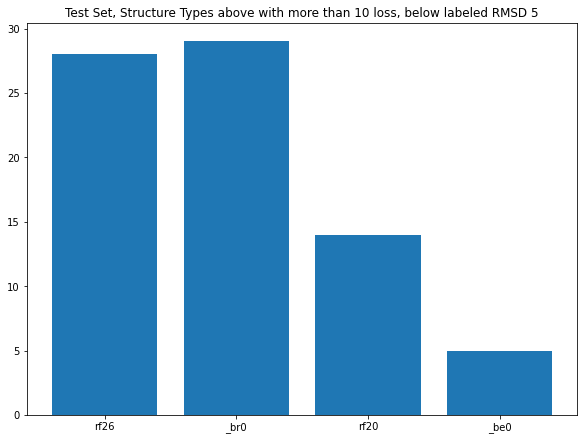

Prediction below 0: Label 4.0850, Pred -0.2006
5S and tRNA Test Set
Minimum Loss: Label = 5.4990, Prediction = 5.4960, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 26.8719, Loss = 26.3719
Mean Test loss: 	 4.2860
Std. Dev. of Test loss:  4.8756
Min loss: 		 0.0000
First Quantile: 	 1.0539
Median: 		 2.8475
Third Quantile: 	 5.6277
Max Loss: 		 26.3719
LinregressResult(slope=0.8087531355749966, intercept=1.4738562411841034, rvalue=0.698890112129684, pvalue=1.5678669442712836e-159, stderr=0.025173255701882186, intercept_stderr=0.48902295988619476)


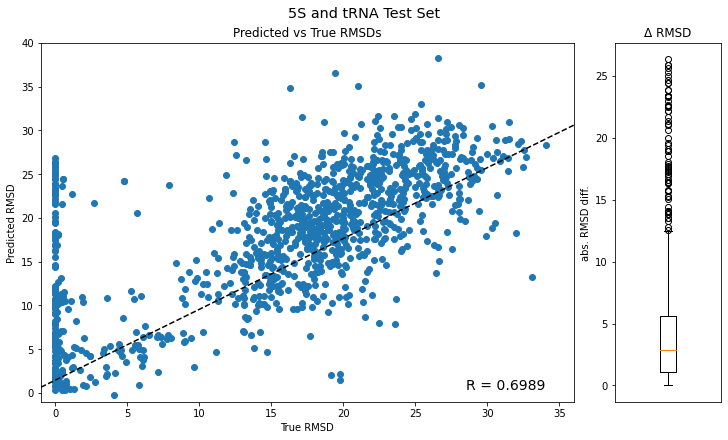

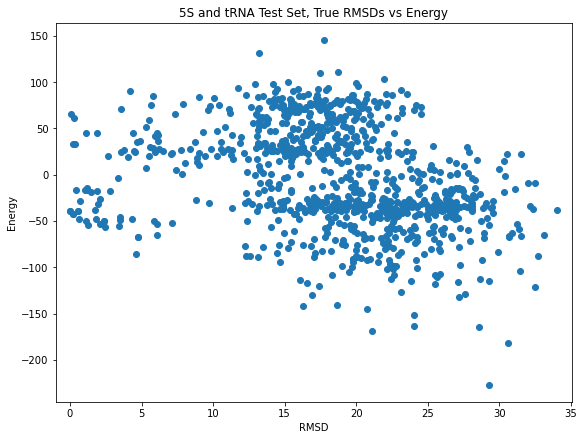

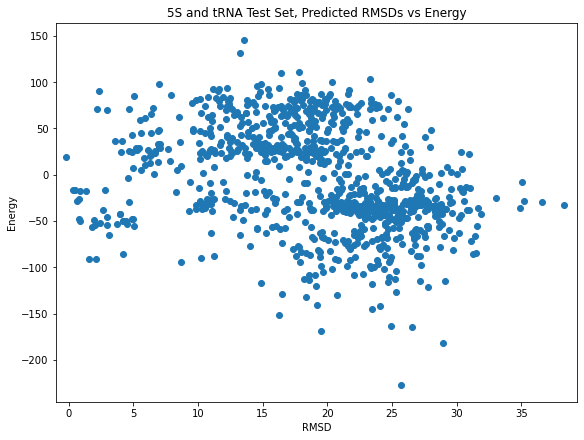

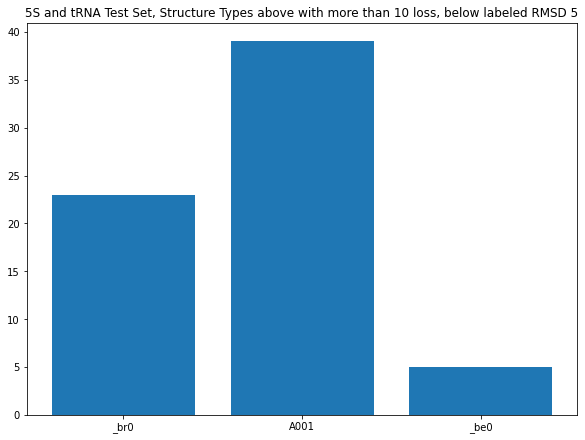

Prediction below 0: Label 0.0000, Pred -0.1997
Prediction below 0: Label 0.0000, Pred -0.1997
Training Set
Minimum Loss: Label = 11.6620, Prediction = 11.6631, Loss = 0.0000
Maximum Loss: Label = 28.2710, Prediction = 13.7781, Loss = 13.9929
Mean Test loss: 	 0.7597
Std. Dev. of Test loss:  1.1676
Min loss: 		 0.0000
First Quantile: 	 0.0583
Median: 		 0.3200
Third Quantile: 	 1.0661
Max Loss: 		 13.9929
LinregressResult(slope=0.9788097176776832, intercept=0.18380154360443157, rvalue=0.9833633425335021, pvalue=0.0, stderr=0.0065672542971569785, intercept_stderr=0.13339876215496801)


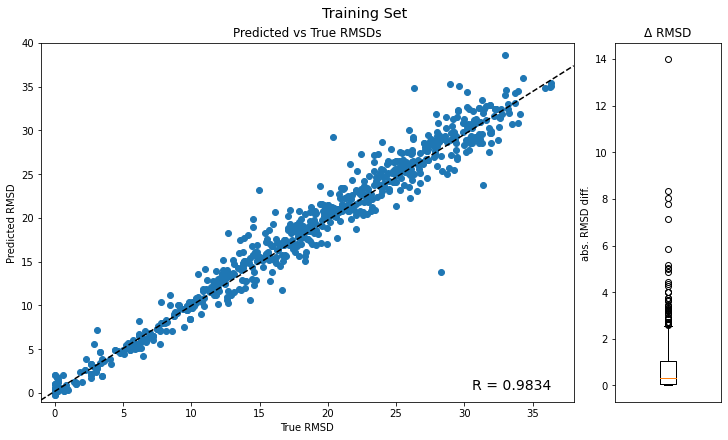

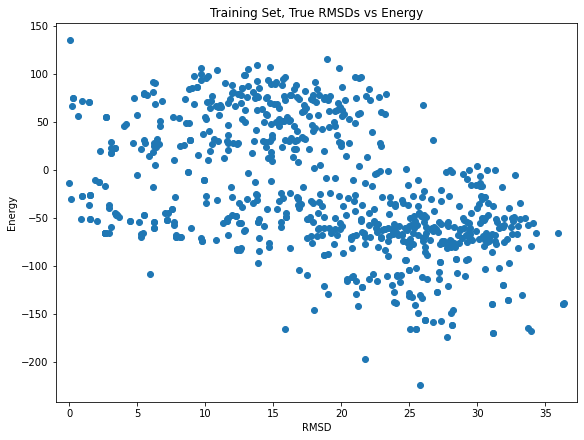

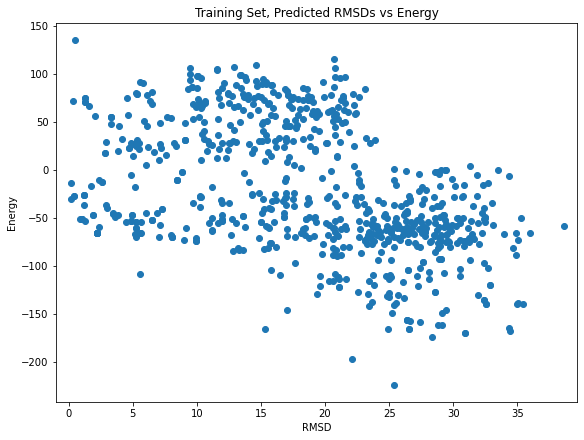

Validation Set
Minimum Loss: Label = 18.2810, Prediction = 18.2532, Loss = 0.0004
Maximum Loss: Label = 61.9850, Prediction = 21.1881, Loss = 40.2969
Mean Test loss: 	 12.7547
Std. Dev. of Test loss:  9.1498
Min loss: 		 0.0004
First Quantile: 	 4.8232
Median: 		 10.9737
Third Quantile: 	 19.8938
Max Loss: 		 40.2969
LinregressResult(slope=0.487478631641447, intercept=12.470148228594573, rvalue=0.16671959440211057, pvalue=0.0008668110424457411, stderr=0.14524448735326767, intercept_stderr=3.3078652655137675)


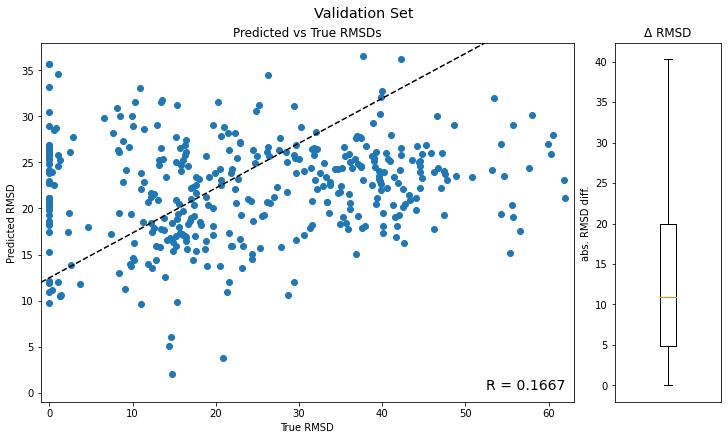

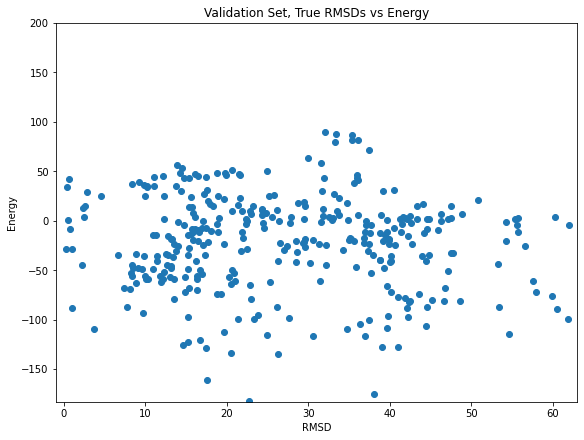

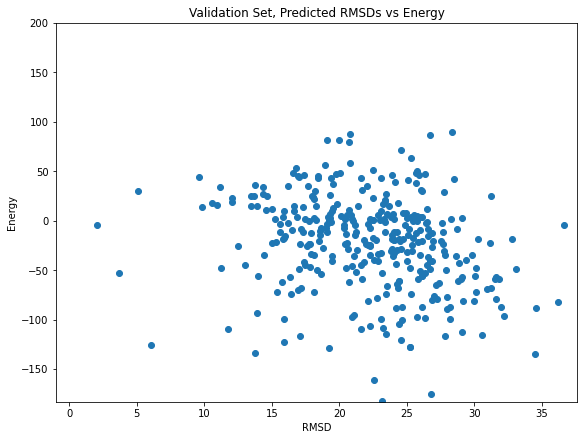

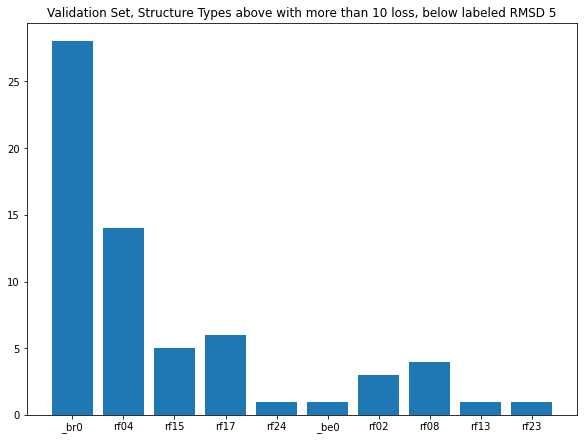

LinregressResult(slope=0.6531496200401659, intercept=7.556825200007838, rvalue=0.4140807481023895, pvalue=7.589373075367955e-63, stderr=0.037207995953071234, intercept_stderr=0.7922350803247674)


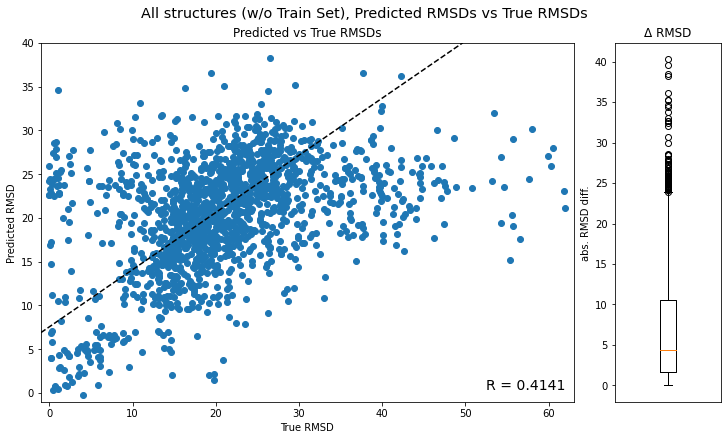

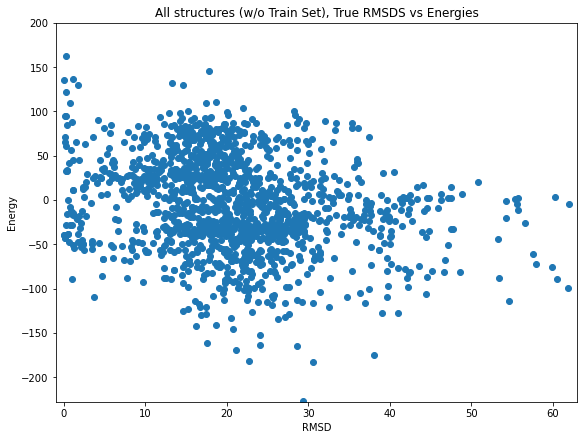

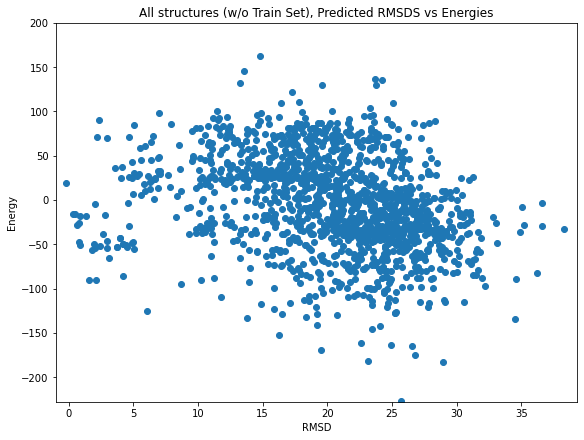

In [7]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9408911330261469, intercept=1.1873736071656111, rvalue=0.9465041405049034, pvalue=4.1899204675391983e-137, stderr=0.019343642688647546, intercept_stderr=0.37044763946214576)


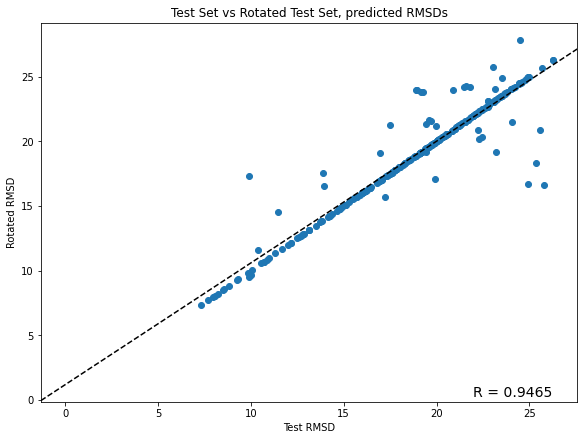

LinregressResult(slope=0.9896806089665002, intercept=0.1986462598586911, rvalue=0.9795326922641329, pvalue=1.7338479737501067e-193, stderr=0.012263698865688762, intercept_stderr=0.1602537767552615)


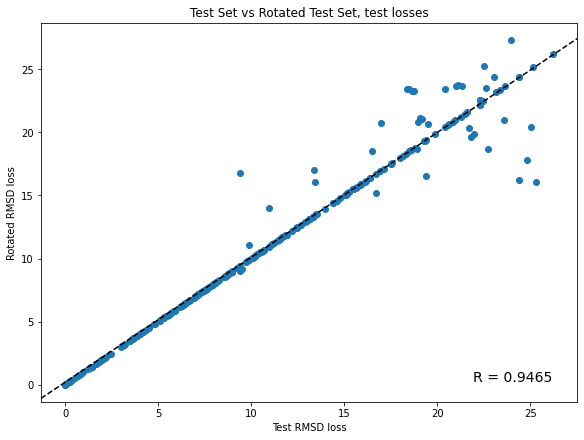

LinregressResult(slope=0.9491713379921269, intercept=0.9586524278209936, rvalue=0.9567660260217538, pvalue=0.0, stderr=0.008776231106002782, intercept_stderr=0.16049323108866345)


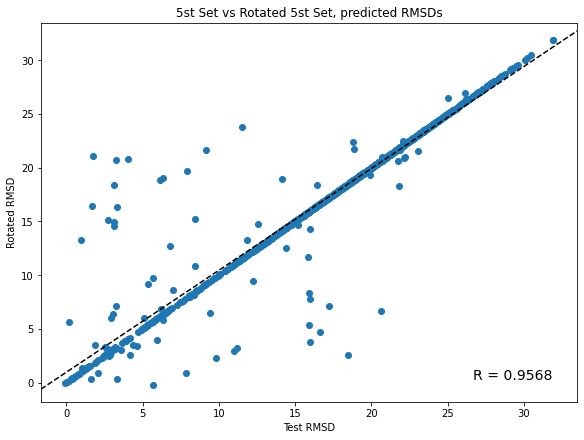

LinregressResult(slope=0.9318922010766466, intercept=0.35586323737150183, rvalue=0.8898256169146389, pvalue=0.0, stderr=0.014534466837887634, intercept_stderr=0.08233355235240626)


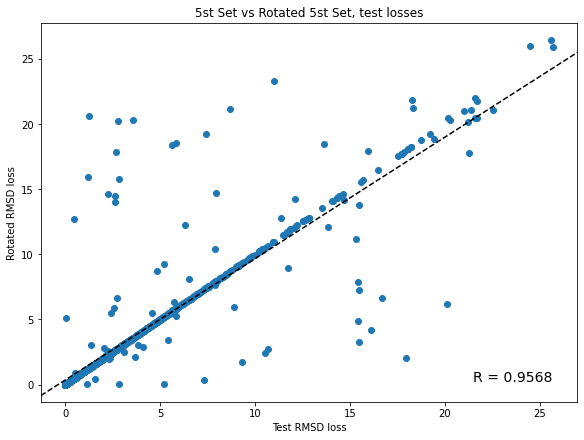

In [6]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")